## Simulating Model

# DGP
$ y_{it} = \alpha_i + \delta_t + \beta \times Treatment_{it} + \gamma \times Post_{t} \times Treatment_{it}+ \epsilon_{it} $

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from linearmodels import PanelOLS

np.random.seed(123)

In [104]:
T = 4
N = 5000

event_period = 3

# generate N random alphas
mu = 185
sigma = 200
alpha = np.random.normal(loc = mu, scale = sigma, size=N) # from a standard normal
# repeat alpha vector T times
alphas = np.tile(alpha, T)

# generate T random deltas
delta = np.random.randn(T)

# define a beta
beta = 0.2
gamma = 0.2

# create treatment vector
half = int(N/2)
treatment_1 = np.ones(half)
treatment_0 = np.zeros(half)
treatment = np.append(treatment_0, treatment_1)
np.random.shuffle(treatment)

# repeat treatment vector T times
treatments = np.tile(treatment, T)

# create individual id's
ids = np.arange(1,N+1)
ids = np.tile(ids, T)

In [105]:
# create a dataframe
df = pd.DataFrame({'id':ids,'alpha':alphas,'treatment':treatments})
period = [[x] * N for x in range(1,T+1)] # list of two lists
df['period'] = np.array(period).reshape(N*T) # array with 2 rows and N columns -> reshape to get one vector with N 1's first and N 2's second, etc.
# fill in delta depending on the period
df['delta'] = df['period'].apply(lambda row: delta[row-1])
# define post dummy
df['post'] = df['period'].apply(lambda row: 1 if row >= event_period else 0)

df['id'] = df['id'].astype(str)

In [106]:
# generate epsilon with possible correlation
df['epsilon'] = 0 * df['alpha'] + 0 * df['delta'] + 0 * df['treatment'] + np.random.randn(N *T)
# calculate y : 
df['y'] = df['alpha'] + df['delta'] + beta * df['treatment'] + gamma * df['treatment'] * df['post'] + df['epsilon']

# show sorted df
df.set_index(['id','period']).sort_values(['id','period']).head(T*2)

alpha  treatment     delta  post   epsilon          y
id period                                                           
1  1      -32.126121        1.0  0.318764     0  0.549026 -31.058331
   2      -32.126121        1.0  1.511104     0  0.456993 -29.958024
   3      -32.126121        1.0 -1.136627     1  2.526856 -30.335891
   4      -32.126121        1.0  0.642460     1 -0.107987 -31.191648
10 1       11.651920        1.0  0.318764     0 -0.529733  11.640950
   2       11.651920        1.0  1.511104     0  0.704604  14.067627
   3       11.651920        1.0 -1.136627     1  2.270938  13.186231
   4       11.651920        1.0  0.642460     1  0.278503  12.972882

In [107]:
tab = df.groupby(['treatment','period'])['y'].mean()
tab

treatment  period
0.0        1         191.180950
           2         192.342754
           3         189.713183
           4         191.501297
1.0        1         188.134941
           2         189.314435
           3         186.882815
           4         188.604219
Name: y, dtype: float64

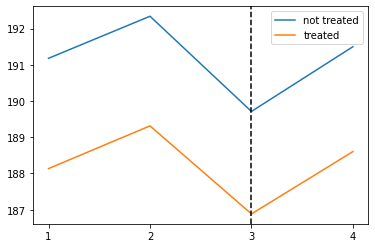

In [108]:
periods = [x for x in range(1,T+1)]

fig, ax = plt.subplots()  
plt.plot(periods,[tab[0][p] for p in periods], label = 'not treated')
plt.plot(periods,[tab[1][p] for p in periods], label = 'treated')
plt.xticks(periods)
plt.axvline(event_period, linestyle='dashed', color='black')
plt.legend()
plt.show()

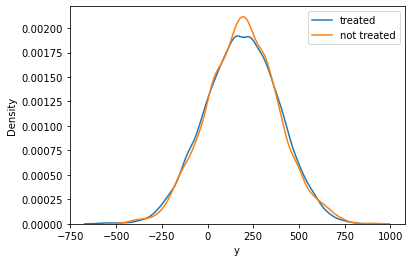

In [109]:
fig, ax = plt.subplots()
sns.kdeplot(df[df.treatment == 1]['y'], ax = ax, label = 'treated')
sns.kdeplot(df[df.treatment == 0]['y'], ax = ax, label = 'not treated')
plt.legend()
plt.show()

In [110]:
# simple ols regression
# use + C(id) in formula to include id dummies -> gets a long list of parameters in summary table, haven't figured out how to avoid this yet
model = ols(formula='y ~ alpha + delta + treatment + treatment * post', data = df)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.541e+08
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:31:18   Log-Likelihood:                -28509.
No. Observations:               20000   AIC:                         5.703e+04
Df Residuals:                   19994   BIC:                         5.708e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0175      0.018      0.972      0.331      -0.018       0.053
alpha              1.0000    3.6e-05   2.78e+04      0.000       1.000       1.000
delta              0.9849      0.009    104.771      0.000       0.966       1.003
treatment          0.2103      0.020     10.447      0.000       0.171       0.250
post              -0.0101      0.023     -0.441      0.659      -0.055       0.035
treatment:post     0.1734      0.028      6.091      0.000       0.118       0.229
==============================================================================
Omnibus:                        4.721   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                4.703
Skew:                           0.030   Prob(JB):                       0.0952
Kurtosis:                       2.954   Cond. No.                     1.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [111]:
# need mulitindexed dataframe
df = df.set_index(['id','period'], drop = False)

In [112]:
# Panel Ols regression
df['interact'] = df['treatment'] * df['post']
# define exogenous variables
exog_vars = ['interact']
# add a constant
exog = sm.add_constant(df[exog_vars])
# estimate model
mod = PanelOLS(dependent=df['y'], exog=exog,
             entity_effects=True,
             time_effects=True,drop_absorbed=True)

res = mod.fit(cov_type='clustered', cluster_entity=True)
res

Dep. Variable:,y,R-squared:,0.0025
Estimator:,PanelOLS,R-squared (Between):,-3.326e-06
No. Observations:,20000,R-squared (Within):,-0.0291
Date:,"Wed, Mar 30 2022",R-squared (Overall):,-4.512e-06
Time:,11:31:18,Log-likelihood,-2.547e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,37.707
Entities:,5000,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,14996)"
Min Obs:,4.0000,,
Max Obs:,4.0000,F-statistic (robust):,27.725
